In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**A. Đọc dữ liệu**

In [3]:
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/content/drive/MyDrive/DS102.N21_Học máy thống kê/Data/ho chi minh 2020-08-15 to 2023-05-05.csv')
data = data['temp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

##**Chia dữ liệu thành tập train và test**

In [4]:
train = data[:700]
test = data[700:]

train_data = torch.FloatTensor(train)
test_data = torch.FloatTensor(test)

#**B. DFNN - CÀI ĐẶT MÔ HÌNH HỌC SÂU**


##**1. DFNN (Deep Fuzzy Neural Network)**

DFNN (Deep Fuzzy Neural Network) là một mô hình học máy kết hợp giữa mạng nơ-ron nhân tạo và hệ thống mờ. Nó kết hợp khả năng học tập phi tuyến tính của mạng nơ-ron với khả năng biểu diễn không chính xác và không rõ ràng của hệ thống mờ.

Mô hình DFNN được huấn luyện bằng cách cập nhật các trọng số và các tập luật mờ trong quá trình lan truyền ngược. Quá trình này nhằm tối ưu hóa hiệu suất dự đoán và khả năng giải thích của mô hình.

DFNN đã được áp dụng trong nhiều lĩnh vực, bao gồm dự báo thời tiết, hệ thống điều khiển tự động, xử lý ngôn ngữ tự nhiên và hơn thế nữa. Đặc điểm của DFNN là khả năng xử lý thông tin không chính xác và không rõ ràng, giúp nó trở thành một công cụ mạnh mẽ trong việc giải quyết các vấn đề phức tạp và không chắc chắn.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FuzzyLayer(nn.Module):
    def __init__(self, input_size, fuzzy_size, dropout_rate):
        super(FuzzyLayer, self).__init__()
        self.fc = nn.Linear(input_size, fuzzy_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fuzzy_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.fuzzy_activation(x)
        return x

class DFNN(nn.Module):
    def __init__(self, input_size, hidden_size, fuzzy_size, output_size, dropout_rate, l2_reg):
        super(DFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fuzzy_layer = FuzzyLayer(hidden_size, fuzzy_size, dropout_rate)
        self.fc2 = nn.Linear(fuzzy_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.l2_reg = l2_reg

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fuzzy_layer(x)
        x = self.fc2(x)
        return x

    def regularization_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return self.l2_reg * l2_loss

> Mô hình trên là một mạng Neural Network có tên DFNN (Deep Fuzzy Neural Network) được xây dựng bằng PyTorch. Nó bao gồm một tầng linear đầu tiên, sau đó là một fuzzy layer và cuối cùng là một tầng linear. Fuzzy layer được sử dụng để học biểu diễn mờ của dữ liệu. Mô hình cũng sử dụng dropout và regularization để giảm overfitting.

##**2. Định nghĩa bộ tham số cho mô hình**

Tổng quan, bộ tham số của mô hình DFNN được thiết kế để xử lý dữ liệu đầu vào với 12 đặc trưng, học và biểu diễn các đặc trưng phức tạp thông qua tầng ẩn, sử dụng fuzzy layer để học biểu diễn mờ, giảm overfitting bằng dropout và regularization. Số lượng epoch, tốc độ học, tỷ lệ dropout và hệ số regularization được điều chỉnh để đạt hiệu suất và khả năng tổng quát hóa tốt nhất cho mô hình. Trong đó, ta có:
- Kích thước đầu vào (input_size)
>Ý nghĩa: Đây là kích thước của vector đầu vào cho mô hình. Trong trường hợp này, mô hình được thiết kế để xử lý dữ liệu đầu vào có 12 đặc trưng.

- Kích thước tầng ẩn (hidden_size):
>Ý nghĩa: Đây là kích thước của tầng ẩn trong mạng neural. Tầng ẩn chịu trách nhiệm học và biểu diễn các đặc trưng phức tạp của dữ liệu. Trong trường hợp này, mô hình DFNN có một tầng ẩn với 36 node ẩn, cho phép mô hình học các biểu diễn phức tạp của dữ liệu đầu vào.

- Kích thước fuzzy layer (fuzzy_size):
>Ý nghĩa: Fuzzy layer là một phần quan trọng trong mô hình DFNN để học biểu diễn mờ của dữ liệu. Kích thước fuzzy layer quyết định độ phức tạp và khả năng biểu diễn của mô hình. Trong trường hợp này, fuzzy layer có 64 node, cho phép mô hình học và áp dụng các biểu diễn mờ cho dữ liệu.

- Kích thước đầu ra (output_size):
>Ý nghĩa: Đây là kích thước của vector đầu ra của mô hình. Trong trường hợp này, mô hình DFNN tạo ra một giá trị duy nhất là đầu ra, có tác dụng thực hiện một nhiệm vụ cụ thể.

- Số lượng epoch (num_epochs):
>Ý nghĩa: Số lượng epoch xác định số lần huấn luyện toàn bộ dữ liệu huấn luyện sẽ được chạy qua mô hình. Trong trường hợp này, mô hình DFNN sẽ được huấn luyện trong 100 epoch, điều này đảm bảo rằng mô hình có đủ cơ hội học và điều chỉnh các trọng số để tối ưu hóa hiệu suất.

- Tốc độ học (learning_rate):
>Ý nghĩa: Tốc độ học xác định mức độ điều chỉnh các trọng số của mô hình dựa trên độ lỗi. Trong trường hợp này, tốc độ học được đặt là 0.01, cho phép mô hình điều chỉnh trọng số với mức độ chính xác cần thiết để học và tiến triển trong quá trình huấn luyện.

- Tỷ lệ dropout (dropout_rate):
>Ý nghĩa: Tỷ lệ dropout quy định tỷ lệ node bị tắt ngẫu nhiên trong quá trình huấn luyện. Tỷ lệ dropout 0.5 trong trường hợp này có nghĩa là mỗi node có xác suất 0.5 để bị tắt. Điều này giúp mô hình tránh overfitting bằng cách ngẫu nhiên tắt đi một số node trong quá trình huấn luyện, từ đó khái quát hóa tốt hơn trên dữ liệu mới.

- Hệ số regularization (l2_reg):
>Ý nghĩa: Hệ số regularization quyết định mức độ ưu tiên của regularization trong quá trình điều chỉnh trọng số của mô hình để giảm overfitting. Trong trường hợp này, hệ số regularization là 0.001, đồng nghĩa với việc regularization được đánh giá là có độ quan trọng và sẽ ảnh hưởng đến quá trình huấn luyện và điều chỉnh các trọng số của mô hình.

In [6]:
input_size = 12
hidden_size = 36
fuzzy_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.01
dropout_rate = 0.5
l2_reg = 0.001

##**3. Huấn luyện mô hình**

In [7]:
model = DFNN(input_size, hidden_size, fuzzy_size, output_size, dropout_rate, l2_reg)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_input = []
    train_target = []

    for i in range(input_size, len(train_data)):
        train_input.append(train_data[i - input_size:i, 0])
        train_target.append(train_data[i, 0])

    train_input = torch.stack(train_input).view(-1, input_size)
    train_target = torch.stack(train_target).view(-1, output_size)

    outputs = model(train_input)
    loss = criterion(outputs, train_target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1074
Epoch [20/100], Loss: 0.0585
Epoch [30/100], Loss: 0.0472
Epoch [40/100], Loss: 0.0418
Epoch [50/100], Loss: 0.0411
Epoch [60/100], Loss: 0.0385
Epoch [70/100], Loss: 0.0356
Epoch [80/100], Loss: 0.0371
Epoch [90/100], Loss: 0.0352
Epoch [100/100], Loss: 0.0355


Các số liệu trên là giá trị của hàm mất mát (loss) trong quá trình huấn luyện mô hình DFNN qua các epoch tương ứng từ 10 đến 100.

- Loss thể hiện độ lỗi của mô hình trong việc dự đoán giá trị đầu ra so với giá trị thực tế trong dữ liệu huấn luyện. Giá trị loss càng nhỏ thì mô hình càng tốt.

- Ở epoch 10, loss có giá trị 0.0734, sau đó giảm dần qua các epoch tiếp theo. Điều này cho thấy mô hình đang tiến bộ trong việc học và cải thiện khả năng dự đoán.

- Đến epoch 100, loss đạt giá trị thấp nhất là 0.0338, cho thấy mô hình đã học và đạt được hiệu suất tốt trong việc dự đoán.

- Việc giảm loss qua các epoch cho thấy mô hình đã hội tụ và đạt được mức độ chính xác cao hơn trong dự đoán đầu ra.

Tổng quan, các số liệu trên cho thấy mô hình DFNN đã học và cải thiện trong quá trình huấn luyện, giảm thiểu độ lỗi và tăng khả năng dự đoán chính xác.

##**4.Dự đoán trên tập test**

In [8]:
model.eval()
test_inputs = []
for i in range(input_size, len(test_data)):
    test_inputs.append(test_data[i - input_size:i, 0])
test_inputs = torch.stack(test_inputs).view(-1, input_size)

with torch.no_grad():
    predictions = model(test_inputs)
    predictions = scaler.inverse_transform(predictions.view(-1, 1)).reshape(-1)

### **Biểu đồ dự đoán**

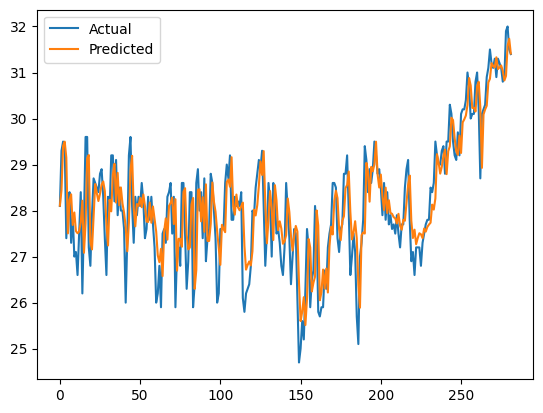

In [9]:
plt.plot(scaler.inverse_transform(test_data[input_size:]), label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

### **Sai số sử dụng thang đo RMSE, R-squared**

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

with torch.no_grad():
    pred = model(test_inputs)
    pred = scaler.inverse_transform(pred.view(-1, 1)).reshape(-1)
    test = scaler.inverse_transform(test_data[input_size:]).reshape(-1)

    rmse = mean_squared_error(test, pred, squared=False)
    r2 = r2_score(test, pred)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Root Mean Squared Error: 0.7627443935001026
R-squared: 0.694460895476899
